In [ ]:
import dlib

from imports import *

In [ ]:
class MeDataset(Dataset):
    """Eyeglasses dataset."""

    def __init__(self, csv_file, root_dir, bs, transform_img=None, transform_land=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_land = transform_land
        self.bs = bs

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.label.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.label.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'label': np.zeros(self.bs).astype('float').reshape(-1, 1)}
        # sample = image

        if self.transform_img:
            sample['image'] = self.transform_img(sample['image'])
            
        if self.transform_land:
            sample['landmarks'] = self.transform_land(sample['landmarks'])
            sample['label'] = self.transform_land(sample['label'])
        
        #sample['label'] = sample['label'].reshape(-1).view(-1)

        return sample['image'], sample['landmarks'].reshape(-1), sample['label'].reshape(-1)

In [ ]:
t_img = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

t_land = transforms.Compose([
    transforms.ToTensor()
])

data_dir = 'data/agn_me_extras160'
#image_datasets = datasets.ImageFolder(data_dir, data_transforms)
image_datasets = MeDataset('data/bboxes_fnames.csv', 'data/agn_me_extras160/Michael_Chaykowsky', 
                           bs = 1, transform_img=t_img, transform_land=t_land)
dataloader_me = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)

In [115]:
data = next(iter(dataloader_me))

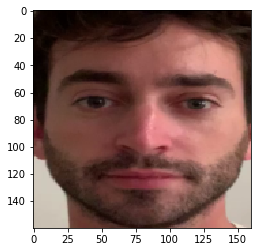

In [116]:
plt.imshow(np.transpose(utils.make_grid(data[0], padding=2, normalize=True),(1,2,0)))

In [ ]:
predictor_path = "data/shape_predictor_68_face_landmarks.dat"
face_rec_model_path = "data/dlib_face_recognition_resnet_model_v1.dat"

cnn_face_detector = dlib.cnn_face_detection_model_v1("data/mmod_human_face_detector.dat")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [ ]:
coords = []
for frame, _, labels in dataloader_me:
    print(frame[0].shape)
    frame = np.transpose(to_np(frame[0]), (1,2,0)) * 255
    frame = frame.astype('uint8')
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print(frame.shape)
    dets = cnn_face_detector(frame, 1)
    d = dets[0]
    shape = predictor(frame, d.rect)

    glassWidth = abs(shape.part(16).x - shape.part(1).x)
    glassHeight = int(glassWidth * origGlassHeight / origGlassWidth)

    y1 = int(shape.part(24).y)
    y2 = int(y1 + glassHeight)
    x1 = int(shape.part(27).x - (glassWidth/2))
    x2 = int(x1 + glassWidth)

    if y1 < 0: 
        glassHeight = glassHeight - abs(y1)
        y1 = 0
    if y2 > frame.shape[0]: glassHeight = glassHeight - (y2 - frame.shape[0])
    if x1 < 0: 
        glassWidth = glassWidth - abs(x1)
        x1 = 0
    if x2 > frame.shape[1]: glassWidth = glassWidth - (x2 - frame.shape[1])
    
    coords.append([x1, x2, y1, y2, glassHeight, glassWidth])

In [ ]:
pd.concat([
    pd.read_csv('data/bboxes_fnames.csv'), 
    pd.DataFrame(coords, columns=['x1','x2','y1','y2','h','w'])], 
    axis=1).to_csv('bboxes_fnames.csv', index=False)